In [2]:
import numpy as np

import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show

import matplotlib.pyplot as plt

import geopandas as gpd
import pandas as pd

#import json
#from osgeo import gdal
import glob
import os.path

from __future__ import division
import os
import affine
    
from rasterio.crs import CRS
from rasterio.enums import Resampling
from rasterio import shutil as rio_shutil
from rasterio.vrt import WarpedVRT


In [3]:
#Función que busca los archivos dentro de una carpeta de Sentinel 2
def getbandas (lista_archivos):
    sentinel2_list = []
    
    for file in lista_archivos[0:35]:
        base = os.path.basename(file)
        banda = base.split(sep="_")[2]+"_"+base.split(sep="_")[3]    
        #print(banda)
        if banda == "B01_60m.jp2":
            B1 = file
            sentinel2_list.append(B1)
        if banda == "B02_10m.jp2":
            B2 = file
            sentinel2_list.append(B2)
        if banda == "B03_10m.jp2":
            B3 = file
            sentinel2_list.append(B3)
        if banda == "B04_10m.jp2":
            B4 = file
            sentinel2_list.append(B4)
        if banda == "B05_20m.jp2":
            B5 = file
            sentinel2_list.append(B5)
        if banda == "B06_20m.jp2":
            B6 = file
            sentinel2_list.append(B6)
        if banda == "B07_20m.jp2":
            B7 = file
            sentinel2_list.append(B7)
        if banda == "B08_10m.jp2":
            B8 = file
            sentinel2_list.append(B8)
        if banda == "B8A_20m.jp2":
            B8A = file
            sentinel2_list.append(B8A)
        if banda == "B09_60m.jp2":
            B9 = file
            sentinel2_list.append(B9)
        if banda == "B10_60m.jp2":
            B10 = file
            sentinel2_list.append(B10)
        if banda == "B11_20m.jp2":
            B11 = file
            sentinel2_list.append(B11)
        if banda == "B12_20m.jp2":
            B12 = file
            sentinel2_list.append(B12)
            
    return sentinel2_list 

In [68]:
#Función que crea un diccionario con los datasets despues que se recortan por una extensión, se reproyectan y se resamplean 
def getbandas2 (lista_archivos,res):
    sentinel2_tiff_list = {}
    resol = str(res)
    
    for file in lista_archivos[0:35]:
        base = os.path.basename(file)
        banda = base.split(sep="_")[5]
        resol_i = base.split(sep="_")[3][0:2]
        if banda == "B01.GTiff" and resol_i == resol:
            B1 = file
            img = rio.open(B1)
            sentinel2_tiff_list['B1']=img
        if banda == "B02.GTiff" and resol_i == resol:
            B2 = file
            img = rio.open(B2)
            sentinel2_tiff_list['B2']=img
        if banda == "B03.GTiff" and resol_i == resol:
            B3 = file
            img = rio.open(B3)
            sentinel2_tiff_list['B3']=img
        if banda == "B04.GTiff" and resol_i == resol:
            B4 = file
            img = rio.open(B4)
            sentinel2_tiff_list['B4']=img
        if banda == "B05.GTiff" and resol_i == resol:
            B5 = file
            img = rio.open(B5)
            sentinel2_tiff_list['B5']=img
        if banda == "B06.GTiff" and resol_i == resol:
            B6 = file
            img = rio.open(B6)
            sentinel2_tiff_list['B6']=img
        if banda == "B07.GTiff" and resol_i == resol:
            B7 = file
            img = rio.open(B7)
            sentinel2_tiff_list['B7']=img
        if banda == "B08.GTiff" and resol_i == resol:
            B8 = file
            img = rio.open(B8)
            sentinel2_tiff_list['B8']=img
        if banda == "B8A.GTiff" and resol_i == resol:
            B8A = file
            img = rio.open(B8A)
            sentinel2_tiff_list['B8A']=img
        if banda == "B09.GTiff" and resol_i == resol:
            B9 = file
            img = rio.open(B9)
            sentinel2_tiff_list['B9']=img
        if banda == "B10.GTiff" and resol_i == resol:
            B10 = file
            img = rio.open(B10)
            sentinel2_tiff_list['B10']=img
        if banda == "B11.GTiff" and resol_i == resol:
            B11 = file
            img = rio.open(B11)
            sentinel2_tiff_list['B11']=img
        if banda == "B12.GTiff" and resol_i == resol:
            B12 = file
            img = rio.open(B12)
            sentinel2_tiff_list['B12']=img
            
    return sentinel2_tiff_list 

In [5]:
#Leer las bandas
#1. BUSCAR TODOS LOS ARCHIVOS .jp2 dentro de la carpeta de la SENTINEL 2 y crear una lista 
   
files1 = glob.glob(r'C:\Users\Vanina\Downloads\S2A_MSIL2A_20211202T140051_N0301_R067_T20HPH_20211202T164401.SAFE\**\*.jp2', 
                   recursive = True)
files1.sort()

sentinel_antes = getbandas(files1)

files2 = glob.glob(r'C:\Users\Vanina\Downloads\S2A_MSIL2A_20211222T140051_N0301_R067_T20HPH_20211222T163347.SAFE\**\*.jp2', 
                   recursive = True)
files2.sort()

sentinel_despues = getbandas(files2)


In [42]:
#Función que recorta, reproyecta y resamplea todas las bandas de Sentinel 2:
#Se debe especificar la lista de los archivos a modificar, el crs de salida con formato EPSG, los límites del recorte, la resolución de salida,
#el ancho y alto de la salida.
#Ojo, las salidas de la función se guardan en el mismo directorio original de las SENTINEL.

def ss_rp_rs(input_files,crs_dest,dest_bounds,res,width,heigh):
    #Cálculo de la matríz de transformación de la imagen que quiero guardar
    left, botton, right, top = dest_bounds
    dest_transform = affine.Affine(res,0.0,left,0.0,-res,top)

    vrt_options = {
        'resapling': Resampling.bilinear,
        'crs': crs_dest,
        'transform': dest_transform,
        'height': height,
        'width': width,
    }

    for path in input_files:
        resol = str(res)
        with rio.open(path) as src:
            with WarpedVRT(src,**vrt_options) as vrt:
                data=vrt.read()
                for _, window in vrt.block_windows():
                    data = vrt.read(window=window)

                directory, file = os.path.split(path)
                archivo = "ss_rep_res_"+ resol + "_" + file.split(sep="_")[1]+"_"+file.split(sep="_")[2] +'.GTiff'
                outfile = os.path.join(directory,archivo)
                rio_shutil.copy(vrt,outfile,driver='GTiff')
                print('Creada: ', archivo, 'en: ',directory)
    return print("Proceso Finalizado")
            

In [43]:
#REPROYECTA, RECORTAR Y RESAMPLEAR TODAS LAS BANDAS

# 1. Elegir crs de destino
crs_dest = 'EPSG:5347'

# 2. Elegir los límites del recorte como: left,botton,right,top
dest_bounds = 5325000,6204000,5413000,6264000 

# 3. Indicar la resolución de salida para que calcule el ancho y el alto de salida
res = 40
width = (dest_bounds[2] - dest_bounds[0])/res
height = (dest_bounds[3] - dest_bounds[1])/res

# 4. A partir de los datos anteriores se corre la función ss_rp_rs que ejecuta las tres operaciones sobre todas las bandas de dos productos S2
ss_rp_rs(sentinel_antes,crs_dest,dest_bounds,res,width,height)
ss_rp_rs(sentinel_despues,crs_dest,dest_bounds,res,width,height)

Creada:  ss_rep_res_40m_20211202T140051_B02.GTiff en:  C:\Users\Vanina\Downloads\S2A_MSIL2A_20211202T140051_N0301_R067_T20HPH_20211202T164401.SAFE\GRANULE\L2A_T20HPH_A033669_20211202T140052\IMG_DATA\R10m
Creada:  ss_rep_res_40m_20211202T140051_B03.GTiff en:  C:\Users\Vanina\Downloads\S2A_MSIL2A_20211202T140051_N0301_R067_T20HPH_20211202T164401.SAFE\GRANULE\L2A_T20HPH_A033669_20211202T140052\IMG_DATA\R10m
Creada:  ss_rep_res_40m_20211202T140051_B04.GTiff en:  C:\Users\Vanina\Downloads\S2A_MSIL2A_20211202T140051_N0301_R067_T20HPH_20211202T164401.SAFE\GRANULE\L2A_T20HPH_A033669_20211202T140052\IMG_DATA\R10m
Creada:  ss_rep_res_40m_20211202T140051_B08.GTiff en:  C:\Users\Vanina\Downloads\S2A_MSIL2A_20211202T140051_N0301_R067_T20HPH_20211202T164401.SAFE\GRANULE\L2A_T20HPH_A033669_20211202T140052\IMG_DATA\R10m
Creada:  ss_rep_res_40m_20211202T140051_B05.GTiff en:  C:\Users\Vanina\Downloads\S2A_MSIL2A_20211202T140051_N0301_R067_T20HPH_20211202T164401.SAFE\GRANULE\L2A_T20HPH_A033669_20211202T1

In [69]:
# Una vez que se han recortado, resampleado y reproyectado las imágenes, creo un direccionario por cada SENTINEL que contiene cada una de las bandas,
#con su correspondiente dataset.
#1. BUSCAR TODOS LOS ARCHIVOS .jp2 dentro de la carpeta de la SENTINEL 2 y crear una lista 
files1_tiff = glob.glob(r'C:\Users\Vanina\Downloads\S2A_MSIL2A_20211202T140051_N0301_R067_T20HPH_20211202T164401.SAFE\**\*.GTiff', 
                   recursive = True)
files1_tiff.sort()

s2_antes = getbandas2(files1_tiff,res)

files2_tiff = glob.glob(r'C:\Users\Vanina\Downloads\S2A_MSIL2A_20211222T140051_N0301_R067_T20HPH_20211222T163347.SAFE\**\*.GTiff', 
                   recursive = True)
files2_tiff.sort()

s2_despues = getbandas2(files2_tiff,res)

In [207]:
#Funcion para normalizar los valores de las bandas
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

In [236]:
#Función para guardar composiones de imágenes RGB: en color natural, infrarrojo, uso agrícola y veg vigorosa. 
def RGB_images(dic,name,path_rgb):
    profile = dic['B2'].profile
    profile.update({"count":3})
    profile['photometric']="RGB"
    profile.update({"dtype":"float64"})
    with rio.open(path_rgb+name+'_colnat.tif', 'w', **profile) as dest:
        dest.write(normalize(dic['B4'].read(1)),1)
        dest.write(normalize(dic['B3'].read(1)),2)
        dest.write(normalize(dic['B2'].read(1)),3)
        
    with rio.open(path_rgb+name+'_infra.tif', 'w', **profile) as dest:
        dest.write(normalize(dic['B8'].read(1)),1)
        dest.write(normalize(dic['B4'].read(1)),2)
        dest.write(normalize(dic['B3'].read(1)),3)

    with rio.open(path_rgb+name+'_usoag.tif', 'w', **profile) as dest:
        dest.write(normalize(dic['B11'].read(1)),1)
        dest.write(normalize(dic['B8A'].read(1)),2)
        dest.write(normalize(dic['B2'].read(1)),3)
        
    with rio.open(path_rgb+name+'_vegvig.tif', 'w', **profile) as dest:
        dest.write(normalize(dic['B8A'].read(1)),1)
        dest.write(normalize(dic['B11'].read(1)),2)
        dest.write(normalize(dic['B2'].read(1)),3)

In [237]:
#Para guardar las imágenes, se indica la ruta de destino: "path_RGB"
path_RGB = 'C:\\Users\\Vanina\\Downloads\\RGB\\'
#Luego se ejecuta la función RGB_images, para obtener los 4 grupos de imágenes seleccionados como imágenes tif de 3 bandas
name1 = "Antes_" + str(res)
name2 = "Despues_" + str(res)
RGB_images(s2_antes,name1,path_RGB)
RGB_images(s2_despues,name2,path_RGB)

Text(0.5, 1.0, 'VEGETACION VIGOROSA')

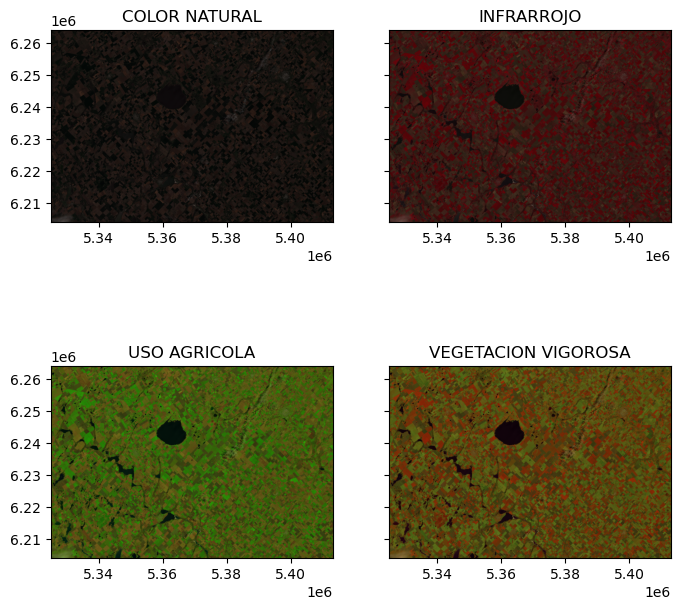

In [250]:
#Visualizacion de las imágenes generadas en las cuatro composiciones - Antes del evento
path_RGB = 'C:\\Users\\Vanina\\Downloads\\RGB\\'
col_nat = rio.open(path_RGB+name1+'_colnat.tif')
infra = rio.open(path_RGB+name1+'_infra.tif')
uso_ag = rio.open(path_RGB+name1+'_usoag.tif')
veg_vig = rio.open(path_RGB+name1+'_vegvig.tif')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), sharey=True)

show(col_nat, transform=col_nat.transform,ax=ax1)#,title="COLOR NATURAL")
show(infra, transform=infra.transform,ax=ax2)#,title="COLOR NATURAL")
show(uso_ag, transform=uso_ag.transform,ax=ax3)#,title="COLOR NATURAL")
show(veg_vig, transform=veg_vig.transform,ax=ax4)#,title="COLOR NATURAL")

ax1.set_title("COLOR NATURAL")
ax2.set_title("INFRARROJO")
ax3.set_title("USO AGRICOLA")
ax4.set_title("VEGETACION VIGOROSA")


In [251]:
#Visualizacion de las imágenes generadas en las cuatro composiciones - Despues del evento
path_RGB = 'C:\\Users\\Vanina\\Downloads\\RGB\\'
col_nat = rio.open(path_RGB+name2+'_colnat.tif')
infra = rio.open(path_RGB+name2+'_infra.tif')
uso_ag = rio.open(path_RGB+name2+'_usoag.tif')
veg_vig = rio.open(path_RGB+name2+'_vegvig.tif')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), sharey=True)

show(col_nat, transform=col_nat.transform,ax=ax1)#,title="COLOR NATURAL")
show(infra, transform=infra.transform,ax=ax2)#,title="COLOR NATURAL")
show(uso_ag, transform=uso_ag.transform,ax=ax3)#,title="COLOR NATURAL")
show(veg_vig, transform=veg_vig.transform,ax=ax4)#,title="COLOR NATURAL")

ax1.set_title("COLOR NATURAL")
ax2.set_title("INFRARROJO")
ax3.set_title("USO AGRICOLA")
ax4.set_title("VEGETACION VIGOROSA")

In [164]:
np.seterr(divide = "ignore",invalid="ignore")
np.geterr()

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [166]:
#Funciones para Calcular ÍNDICES

def NDVI(b8,b4):
    NDVI = (b8 - b4)/(b8 + b4)
    return NDVI

def EVI(b8,b4,b2):
    EVI = 2.5*(b8 - b4)/((b8 + 6*b4 - 7.5*b2)+1)
    return EVI

def AVI(b8,b4):
    AVI = pow((b8 * ( 1 - b4) * (b8 - b4)),(1/3))
    return AVI   

def SAVI(b8,b4):
    SAVI = ((b8 - b4) / (b8 + b4 + 0.428)) * 1.428
    return SAVI   

def MNDWI(b3,b11):
    MNDWI = (b3 - b11) / (b3 + b11) 
    return MNDWI   

Text(0.5, 1.0, 'VARIACIÓN DE NDVI')

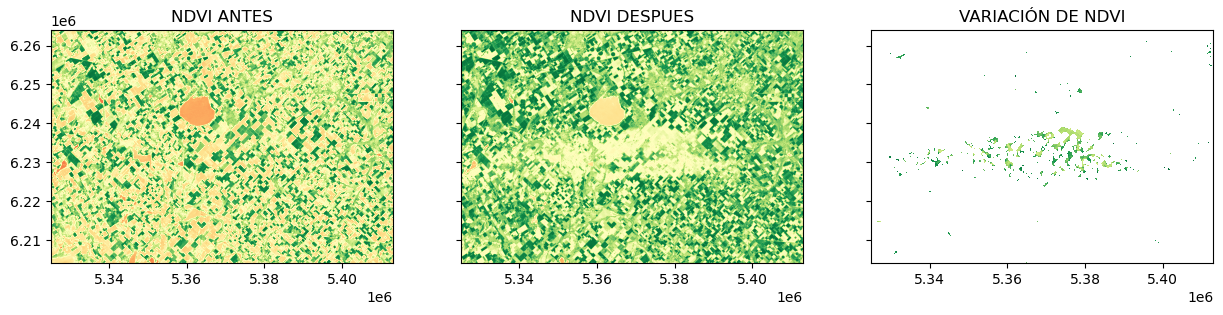

In [259]:
#Calculo NDVI y los visualizao
ndvi_a = NDVI(s2_antes['B8'].read().astype('float64'),s2_antes['B4'].read().astype('float64'))
ndvi_d = NDVI(s2_despues['B8'].read().astype('float64'),s2_despues['B4'].read().astype('float64'))

p_ndvi = (ndvi_d-ndvi_a)*100/ndvi_a
p_ndvi[p_ndvi < -200] = np.nan
p_ndvi[p_ndvi > 0]= np.nan

p_ndvi= np.around(p_ndvi,2)

fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharey=True)
show(ndvi_a,cmap='RdYlGn', transform=s2_antes['B8'].transform,ax=ax1)
show(ndvi_d,cmap='RdYlGn', transform=s2_despues['B8'].transform,ax=ax2)
show(p_ndvi,cmap='RdYlGn', transform=s2_despues['B8'].transform,ax=ax3)
ax1.set_title("NDVI ANTES")
ax2.set_title("NDVI DESPUES")
ax3.set_title("VARIACIÓN DE NDVI")




Text(0.5, 1.0, 'VARIACIÓN DE EVI')

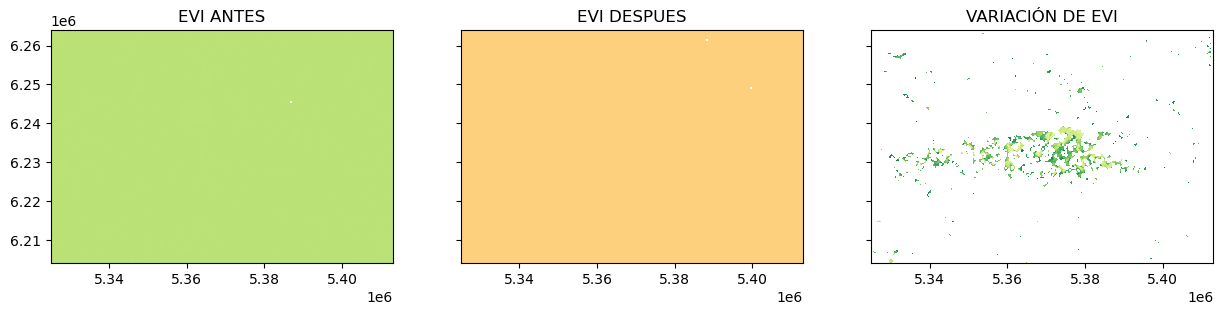

In [260]:
#Calculo EVI y los visualizao
evi_a = EVI(s2_antes['B8'].read().astype('float64'),s2_antes['B4'].read().astype('float64'),s2_antes['B2'].read().astype('float64'))
evi_d = EVI(s2_despues['B8'].read().astype('float64'),s2_despues['B4'].read().astype('float64'),s2_despues['B2'].read().astype('float64'))

p_evi = (evi_d-evi_a)*100/evi_a
p_evi[p_evi < -200] = np.nan
p_evi[p_evi > 0]= np.nan

p_evi= np.around(p_evi,2)

fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharey=True)
show(evi_a,cmap='RdYlGn', transform=s2_antes['B8'].transform,ax=ax1)
show(evi_d,cmap='RdYlGn', transform=s2_despues['B8'].transform,ax=ax2)
show(p_evi,cmap='RdYlGn', transform=s2_despues['B8'].transform,ax=ax3)
ax1.set_title("EVI ANTES")
ax2.set_title("EVI DESPUES")
ax3.set_title("VARIACIÓN DE EVI")



Text(0.5, 1.0, 'VARIACIÓN DE SAVI')

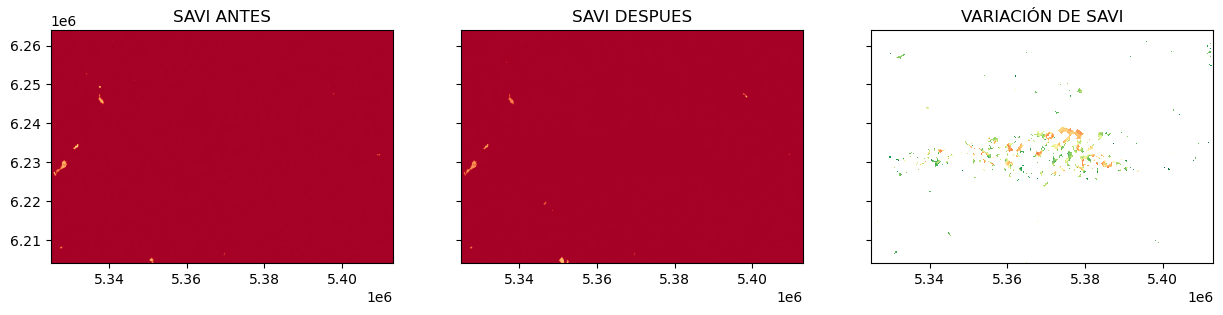

In [261]:
#Calculo SAVI y los visualizo
savi_a = SAVI(s2_antes['B8'].read(),s2_antes['B4'].read())
savi_d = SAVI(s2_despues['B8'].read(),s2_despues['B4'].read())

p_savi = (savi_d-savi_a)*100/savi_a
p_savi[p_savi < -200] = np.nan
p_savi[p_savi > 0]= np.nan

p_savi= np.around(p_savi,2)

fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharey=True)
show(savi_a, cmap='RdYlGn',transform=s2_antes['B8'].transform,ax=ax1)
show(savi_d,cmap='RdYlGn', transform=s2_despues['B8'].transform,ax=ax2)
show(p_savi,cmap='RdYlGn', transform=s2_despues['B8'].transform,ax=ax3)
ax1.set_title("SAVI ANTES")
ax2.set_title("SAVI DESPUES")
ax3.set_title("VARIACIÓN DE SAVI")

Text(0.5, 1.0, 'MNDWI DESPUES')

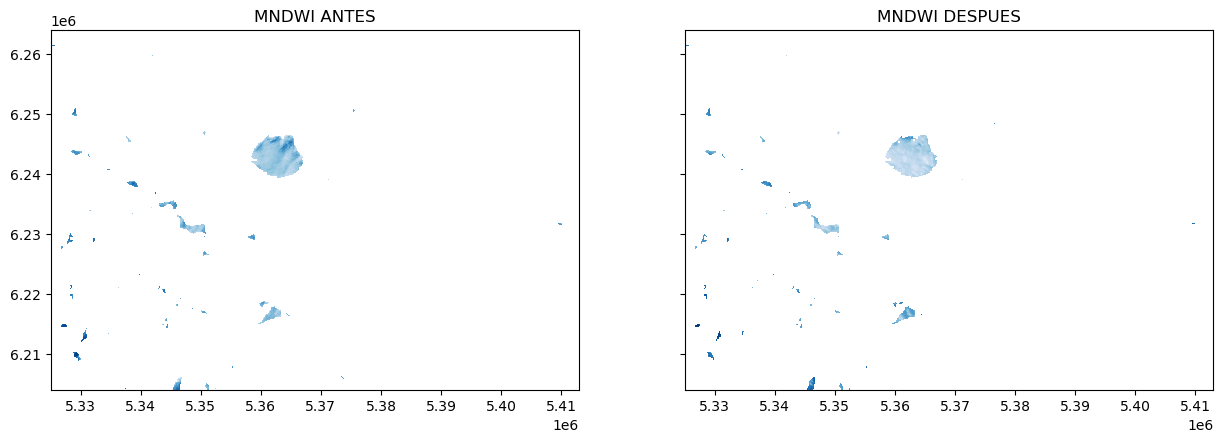

In [266]:
#Calculo MNDWI y veo los cuerpos de agua
mndwi_a = MNDWI(s2_antes['B3'].read().astype('float64'),s2_antes['B11'].read().astype('float64'))
mndwi_d = MNDWI(s2_despues['B3'].read().astype('float64'),s2_despues['B11'].read().astype('float64'))

mndwi_a[mndwi_a < 0.3] = np.nan
mndwi_d[mndwi_d < 0.3] = np.nan

fig, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1, figsize=(15, 15), sharey=True)
show(mndwi_a, cmap = 'Blues', transform=s2_antes['B8'].transform,ax=ax1)
show(mndwi_d, cmap = 'Blues',transform=s2_despues['B8'].transform,ax=ax2)

ax1.set_title("MNDWI ANTES")
ax2.set_title("MNDWI DESPUES")



In [276]:
#Estas son las parcelas

ruta_teodelina = "C:\\Users\\Vanina\\Box\\02 - Synergia - Antec. y GIS\\02 - Sinergia - GIS\\Catastro\\general lopez\\parcelas rurales\\pnr1723 Teodelina.zip"
ruta_vcanas = "C:\\Users\\Vanina\\Box\\02 - Synergia - Antec. y GIS\\02 - Sinergia - GIS\\Catastro\\general lopez\\parcelas rurales\\pnr1719 Villa Cañás.zip"

teodelina = gpd.read_file(ruta_teodelina)
vcanas = gpd.read_file(ruta_vcanas)

teodelina.crs # no tiene crs asignado, no devuelve nada
teodelina_geo = teodelina.set_crs(epsg=5347)
vcanas_geo = vcanas.set_crs(epsg=5347)
teodelina_geo.crs

teodelina_geo.area #area en m2
teodelina_geo["Area"]=round(teodelina_geo.area/10000,2)
teodelina_geo.explore("Area")

vcanas_geo.area #area en m2
vcanas_geo["Area"]=round(vcanas_geo.area/10000,2)
vcanas_geo.explore("Area")

parcelas = pd.concat([teodelina_geo, vcanas_geo])

parcelas.explore("Area")